In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

dataDf = pd.read_csv('calories.csv')

In [57]:
X = dataDf.drop(['Calories', 'User_ID'], axis=1)
y = dataDf['Calories']

features = ['Gender', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate']
num_col = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate']
cat_col = ['Gender']
numerical_features = X[num_col]
categorical_features = X[cat_col]

In [3]:
print('total number of features: ', len(X.columns))
print('total number of samples: ', len(X))

total number of features:  7
total number of samples:  15000


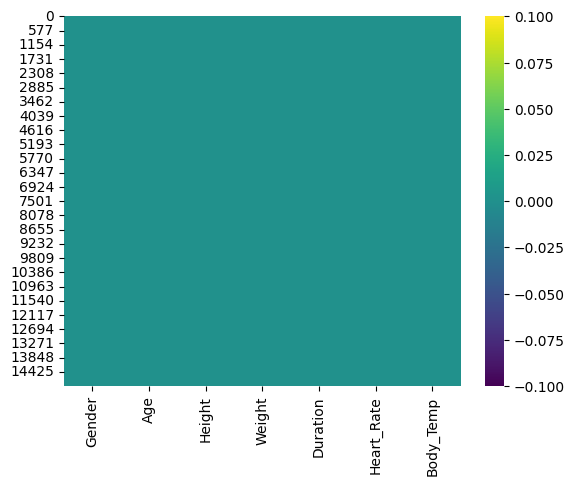

In [4]:
# heat map to visualizes missing values
sns.heatmap(X.isnull(), cbar=True, cmap='viridis')
plt.show()

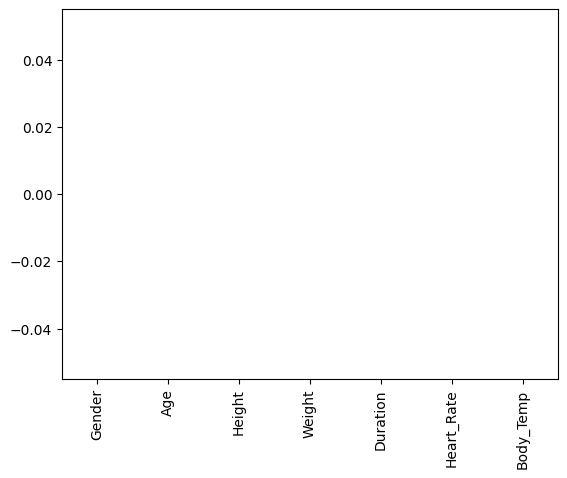

In [5]:
# bat plot to visualizes missing values
X.isnull().sum().plot(kind='bar')
plt.show()

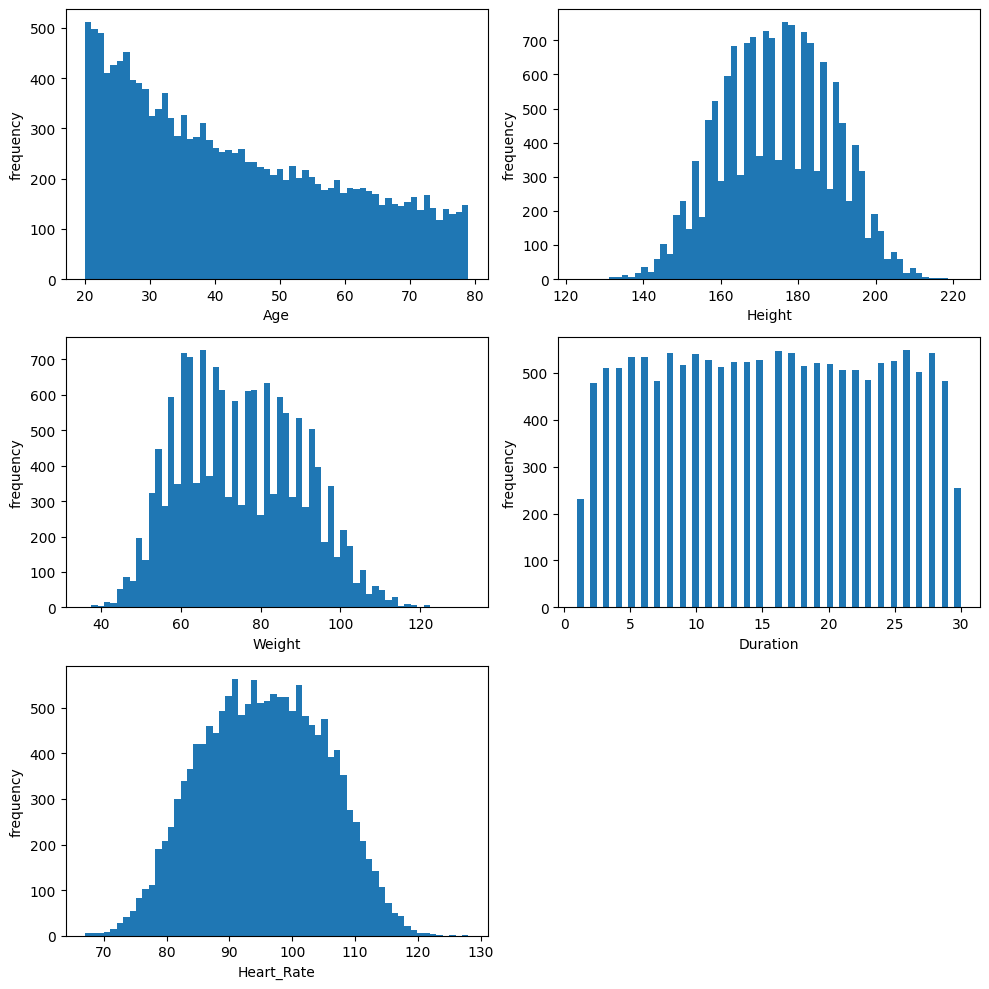

In [6]:
# distribution plot to visualizes the distribution of numerical variable
plt.figure(figsize=(10, 10))
for i, col in enumerate(num_col):
    plt.subplot(3, 2, i + 1)
    plt.hist(X[col], bins=60)
    plt.xlabel(col)
    plt.ylabel('frequency')
plt.tight_layout()
plt.show()


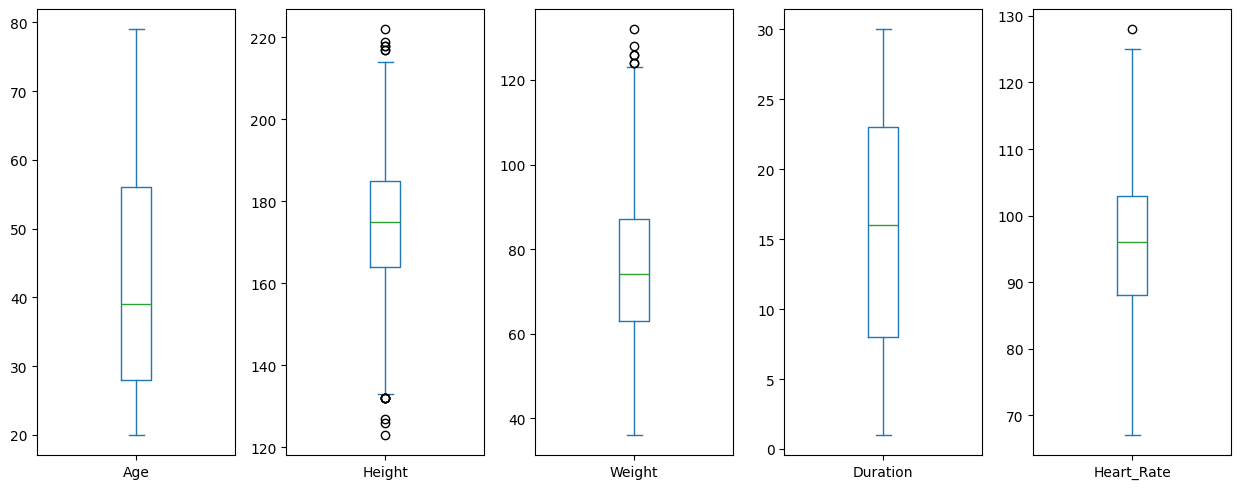

In [7]:
# bar plot for numerical feature to check the outlier
numerical_features.plot(kind='box', subplots=True, layout=(1, 6), figsize=(15, 5))
plt.tight_layout()
plt.show()

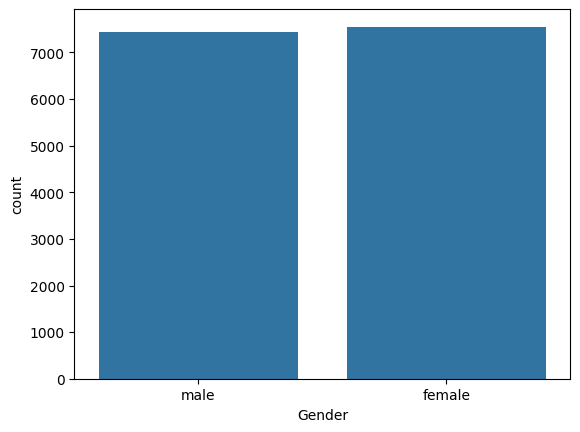

In [8]:
# count plot for categorical data for the check frequency of categorical values
sns.countplot(x=categorical_features['Gender'])
plt.show()

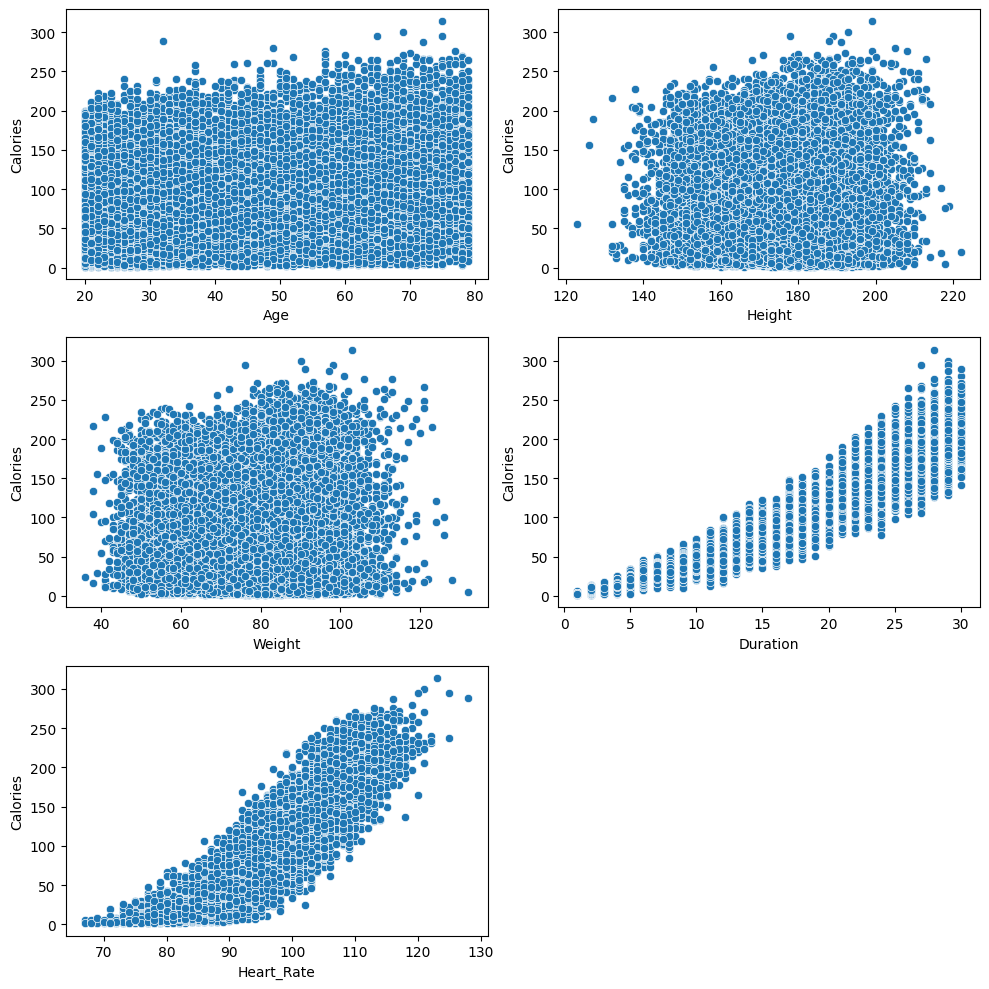

In [9]:
# scatter plot for regression problems to see trends
plt.figure(figsize=(10, 10))
for i, col in enumerate(num_col):
    plt.subplot(3, 2, i + 1)
    sns.scatterplot(x=col, y='Calories', data=dataDf)
    plt.xlabel(col)
plt.tight_layout()
plt.show()

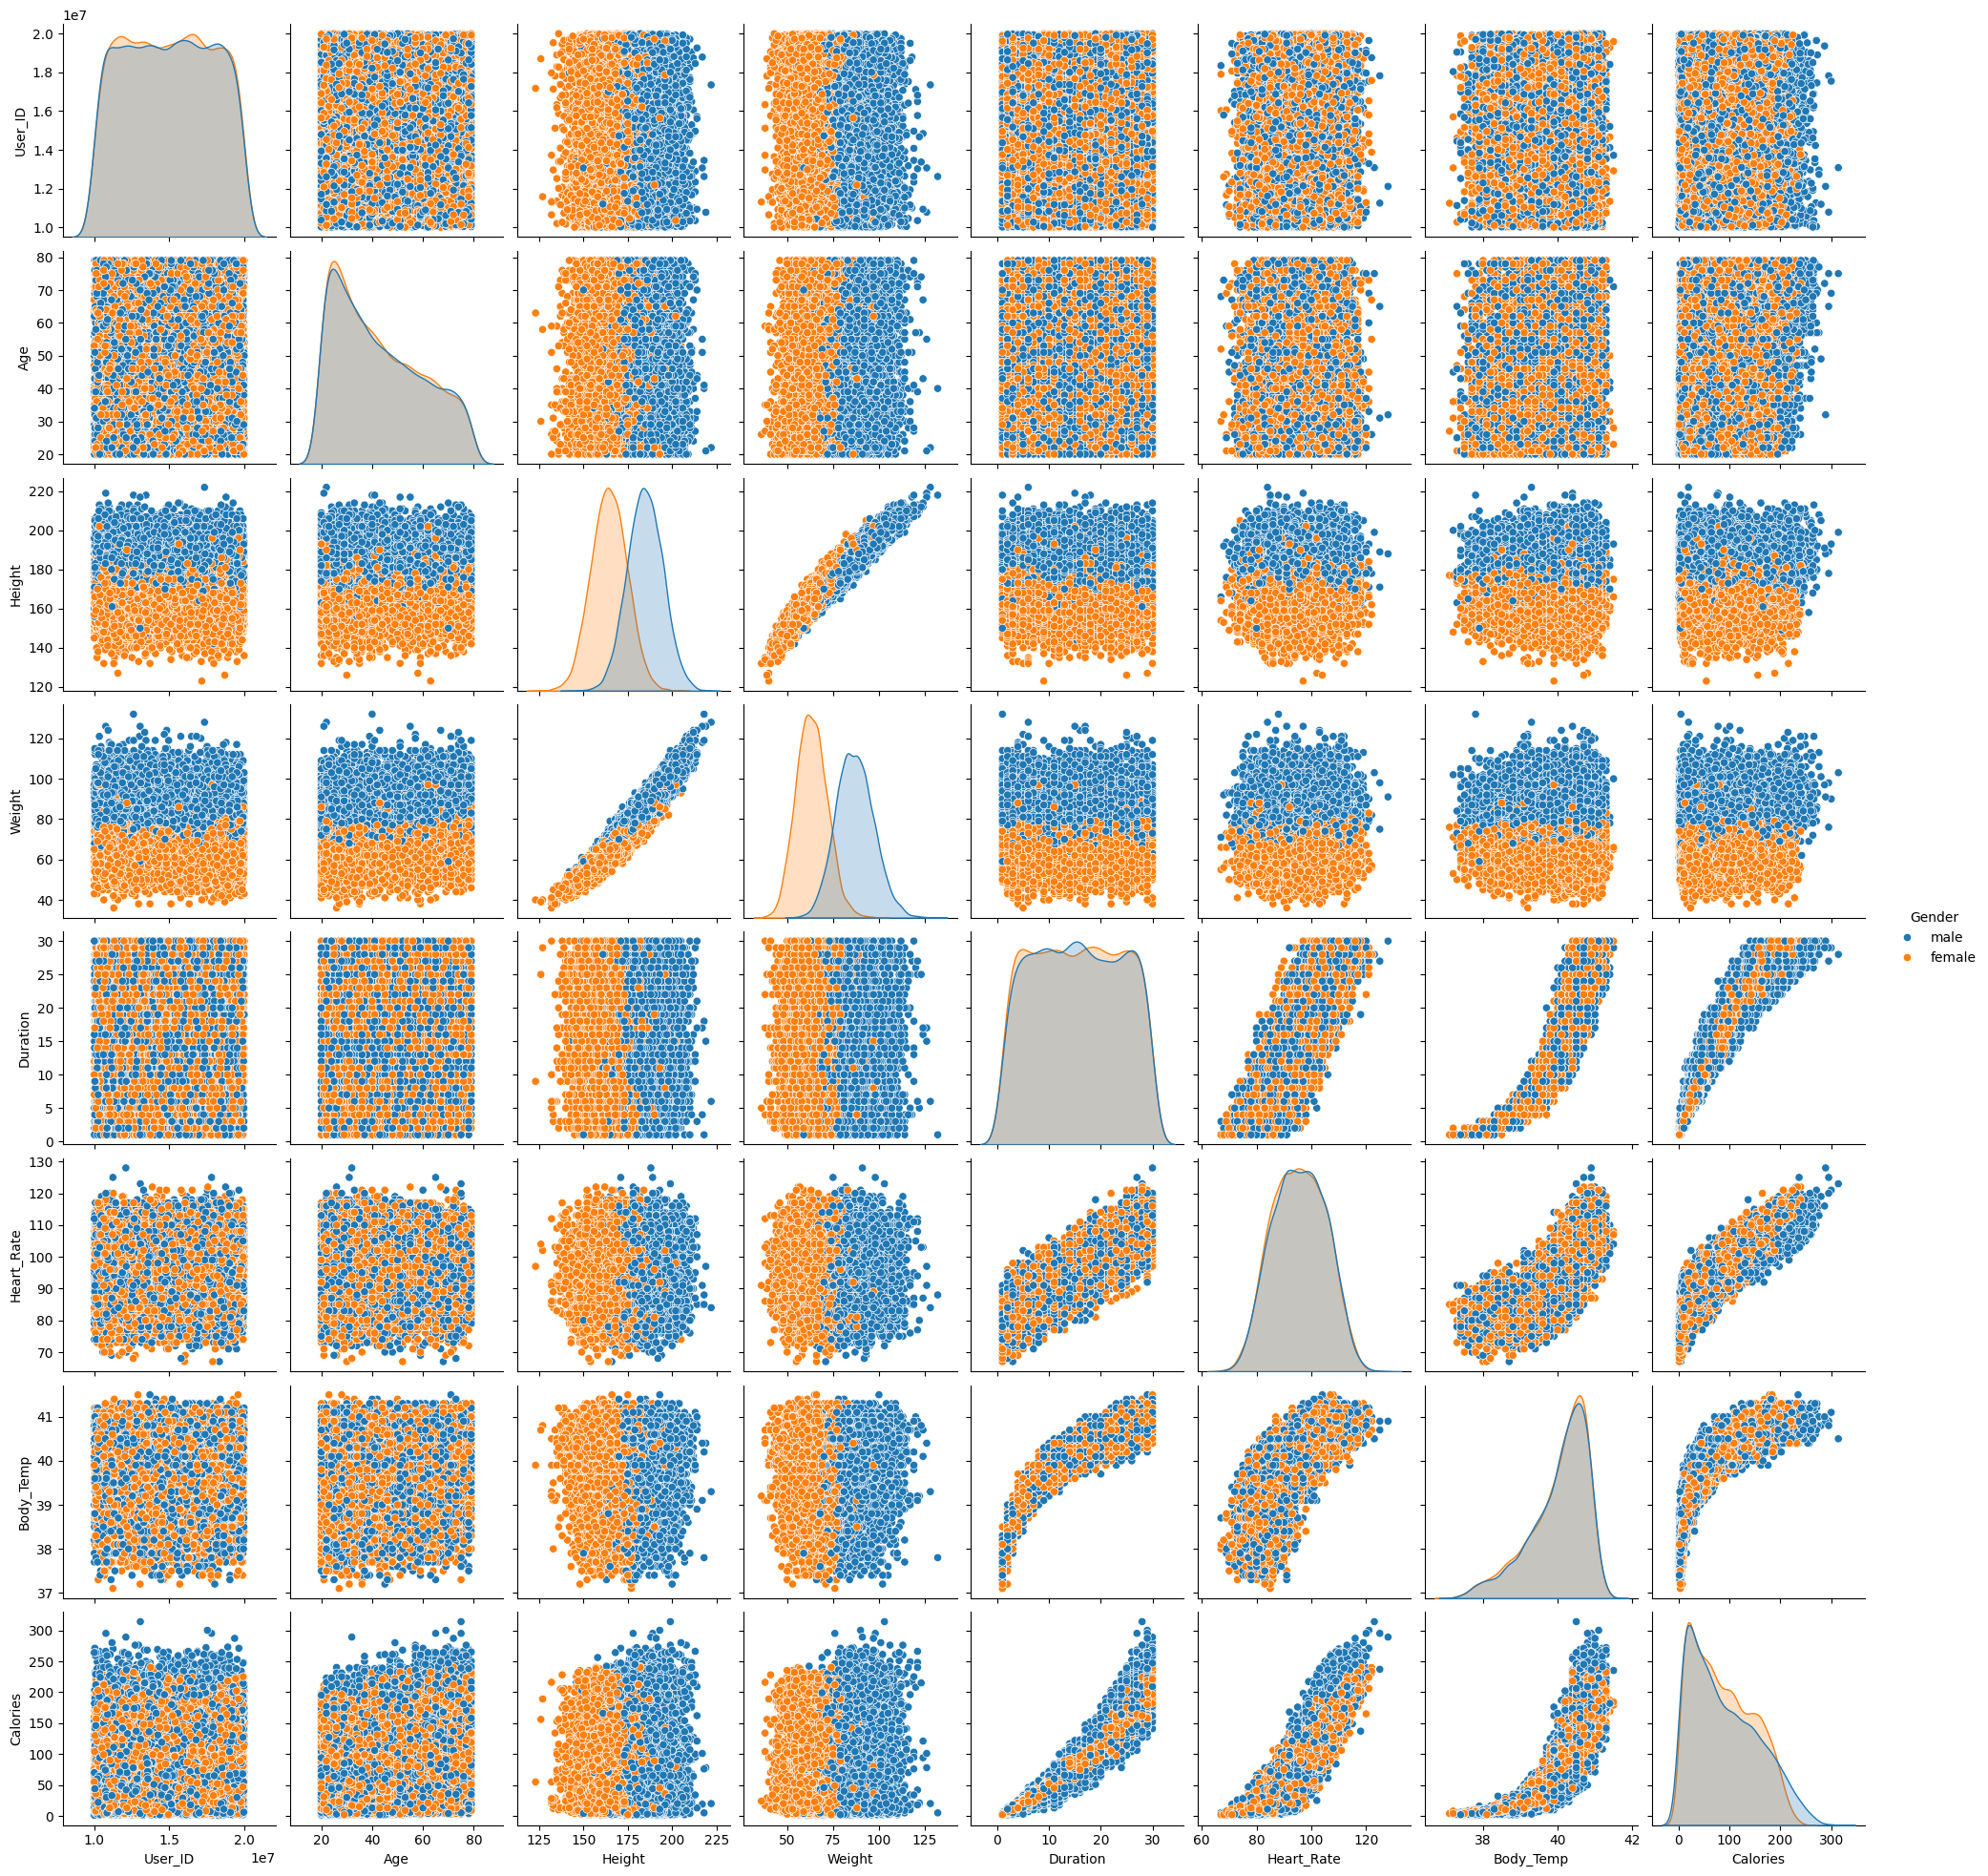

In [10]:
# pair plot to visualize relationships across several features and the target
sns.pairplot(dataDf, hue='Gender')
plt.show()

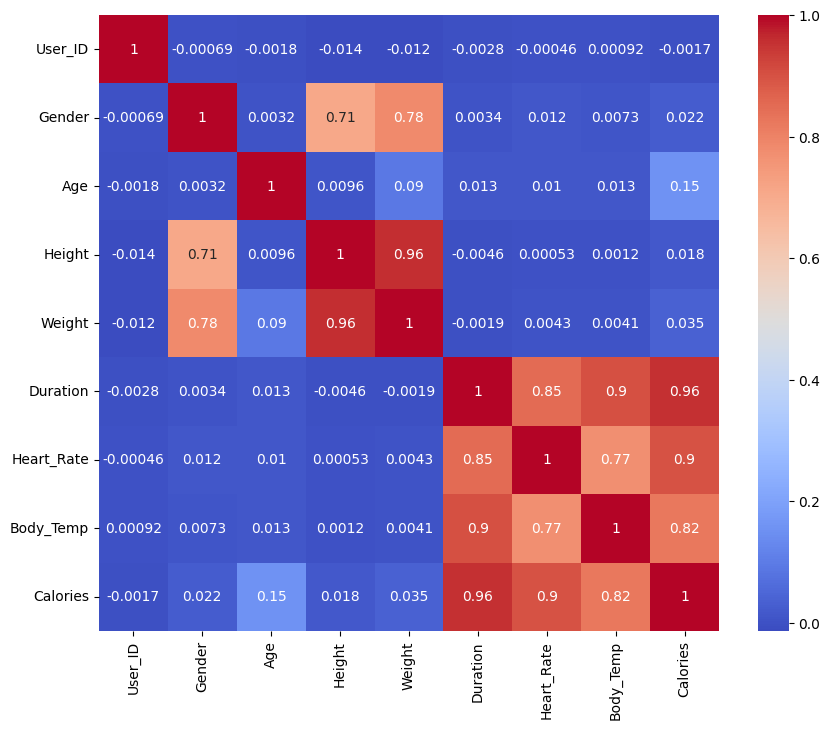

In [11]:
# heat map to show relationships between features
encoder = LabelEncoder()
dataDf['Gender'] = encoder.fit_transform(dataDf['Gender'])
plt.figure(figsize=(10, 8))
sns.heatmap(dataDf.corr(), annot=True, cmap='coolwarm')
plt.show()

In [12]:
from scipy.stats import zscore

# checking for outlier
for col in num_col:
    dataDf['zscore'] = zscore(dataDf[col])
    outliers = dataDf[dataDf['zscore'] > 3]
    print(f'total outlier in {col} column: {len(outliers)}')

total outlier in Age column: 0
total outlier in Height column: 4
total outlier in Weight column: 13
total outlier in Duration column: 0
total outlier in Heart_Rate column: 3


In [13]:
# checking for outlier
for col in num_col:
    Q1 = dataDf['Weight'].quantile(0.25)
    Q3 = dataDf['Weight'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = dataDf[(dataDf['Weight'] < (Q1 - 1.5 * IQR)) | (dataDf['Weight'] > (Q3 + 1.5 * IQR))]
    print(f'total outlier in {col} column: {len(outliers)}')

total outlier in Age column: 6
total outlier in Height column: 6
total outlier in Weight column: 6
total outlier in Duration column: 6
total outlier in Heart_Rate column: 6


In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error


In [58]:
# X['weight_squared'] = X['Weight'] ** 2
# X['heart_rate_weight_ratio'] = X['Heart_Rate'] / X['Weight']
# X['body_temp_age_ratio'] = X['Body_Temp'] / X['Age']
# X['exp_heart_rate'] = np.exp(X['Heart_Rate'])

X['weight_heart_rate'] = X['Weight'] * X['Heart_Rate']
X['heart_rate_weight_ratio'] = X['Heart_Rate'] / X['Weight']

X['duration_heart_rate'] = X['Duration'] * X['Heart_Rate']
X['age_body_temp'] = X['Age'] * X['Body_Temp']

X['heart_rate_squared'] = X['Heart_Rate'] ** 2

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
poly_features = poly.fit_transform(X[['Heart_Rate', 'Duration']])
poly_feature_names = poly.get_feature_names_out(['Heart_Rate', 'Duration'])
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)
X = pd.concat([X, poly_df.iloc[:, 3:]], axis=1)

X['BMI'] = X['Weight'] / (X['Height'] ** 2)

X['work_done'] = X['Weight'] * (X['Duration'] * X['Heart_Rate'])


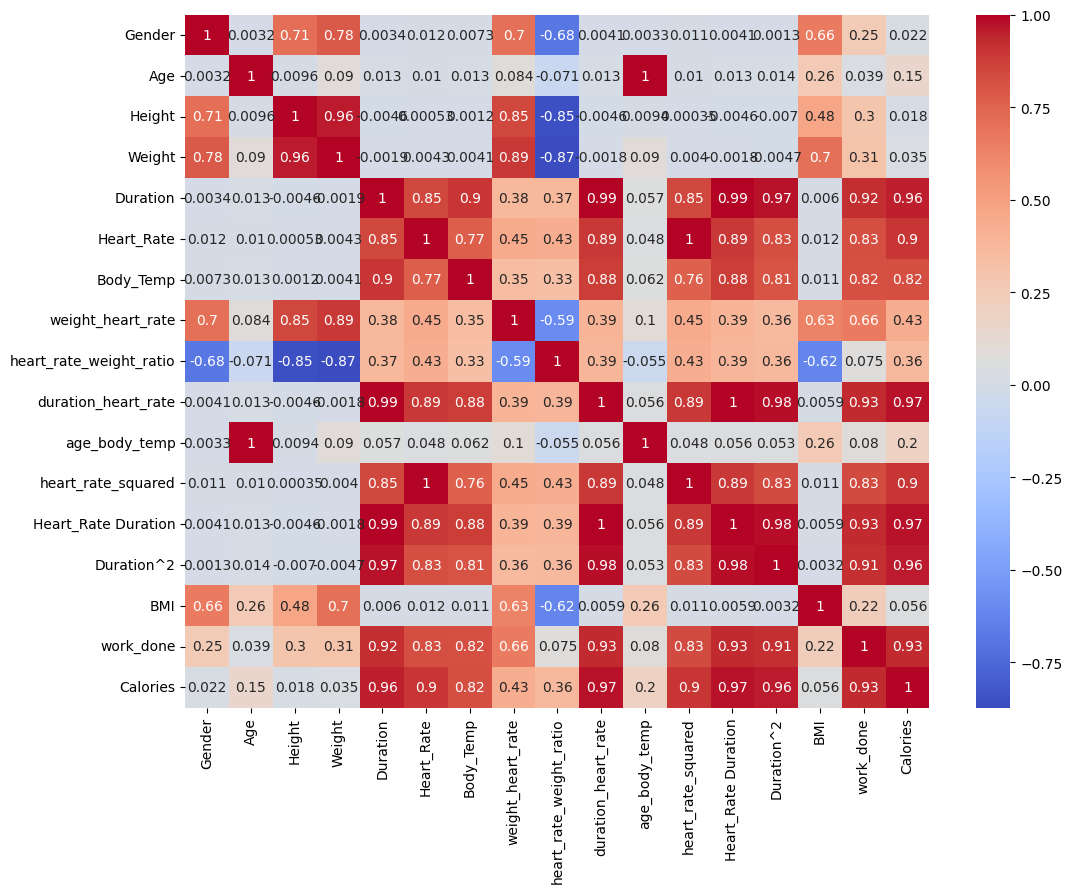

In [63]:
# heat map to show relationships between features
newdf = pd.concat([X, y], axis=1)
encoder = LabelEncoder()
newdf['Gender'] = encoder.fit_transform(newdf['Gender'])
plt.figure(figsize=(12, 9))
sns.heatmap(newdf.corr(), annot=True, cmap='coolwarm')
plt.show()

In [61]:
# imputation of numerical and categorical data
cat_imputer = SimpleImputer(strategy='most_frequent')
X[cat_col] = cat_imputer.fit_transform(X[cat_col])

num_col = X.select_dtypes(include=np.number).columns

num_imputer = SimpleImputer(strategy='mean')
X[num_col] = num_imputer.fit_transform(X[num_col])

# scaling for numerical data
scaler = StandardScaler()
X[num_col] = scaler.fit_transform(X[num_col])

# encoding for categorical data
encoder = LabelEncoder()
X['Gender'] = encoder.fit_transform(X['Gender'])


In [32]:
features_used = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Gender']
X_train, X_test, y_train, y_test = train_test_split(X[features_used], y, test_size=0.3, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MSE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print("Model Coefficients:", model.coef_)
print("Intercept:", model.intercept_)


Mean Squared Error (MSE): 11.529055286539263
Mean Absolute Error (MSE): 8.451945920538373
Root Mean Squared Error (RMSE): 3.3954462573481066
R-squared (R2): 0.9663275127619021
Model Coefficients: [  8.46662365  -2.53875873   4.46824746  55.16591369  19.02872451
 -13.18441782  -1.3529688 ]
Intercept: 90.13846468542995


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MSE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print("Model Coefficients:", model.coef_)
print("Intercept:", model.intercept_)


Mean Squared Error (MSE): 5.866127228414908
Mean Absolute Error (MSE): 4.2934056089657675
Root Mean Squared Error (RMSE): 2.4220089240989404
R-squared (R2): 0.9912825250237938
Model Coefficients: [-1.35053532e-01 -2.00552213e+02 -5.76384152e+00 -2.06149195e+01
 -5.93852201e+01 -1.73109784e+01 -1.00662711e+01  5.99957026e+00
  7.24501492e+00  7.72492173e-02  4.62326953e-02  3.21536351e+01
  5.84060499e+01  2.09684926e+02 -2.99634117e-01  5.84060499e+01
 -2.00972863e-01 -2.15161863e+00  3.32362422e+00]
Intercept: 89.60004648856749


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MSE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print("Model Coefficients:", model.coef_)
print("Intercept:", model.intercept_)


Mean Squared Error (MSE): 5.857240926754537
Mean Absolute Error (MSE): 4.2852217129095695
Root Mean Squared Error (RMSE): 2.4201737389606013
R-squared (R2): 0.9913089163496477
Model Coefficients: [-2.93703497e-01 -2.00648173e+02 -1.08657421e+01 -8.36570427e+00
 -5.91857969e+01 -1.84179229e+01 -1.00623508e+01  3.30938423e+01
  8.12505435e+00  5.82774681e+01  2.09706881e+02  5.61837808e-02
  5.82774681e+01 -1.57982246e-01 -4.13671621e+00  3.29241722e+00]
Intercept: 89.6783701532639


In [28]:
print('-Trainingset Score:',model.score(X_train, y_train))
print('-Testingset Score:',model.score(X_test,y_test))

-Trainingset Score: 0.9913485434867029
-Testingset Score: 0.9913089163496477
